In [2]:
import torch
import torch.nn as nn
from data_process import get_data_loaders, getFeatures
from model.TCN import TemporalConvNet, TCN
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('flights.csv') 
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']
data, train_loader, val_loader, test_loader, d_split = get_data_loaders(data, 24, 10, test_size=0.2, val_size=0.2, 
                                                                        features=select_features, covariates=False)
# features = getFeatures()

In [7]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 24, 7])
torch.Size([64, 10])


In [5]:
class LSTM_LSTM(nn.Module):
    def __init__(self, input_size, output_size, input_len, output_len, lstm_num_hidden, num_layers=1):
        super(LSTM_LSTM, self).__init__()
        self.encoder = nn.LSTM(input_size, lstm_num_hidden, num_layers, batch_first=True)
        self.decoder = nn.LSTM(output_size, lstm_num_hidden, num_layers, batch_first=True)
        self.fc = nn.Linear(lstm_num_hidden, output_size)
        self.input_len = input_len
        self.output_len = output_len

    def forward(self, x):
        # x: (batch_size, input_len, input_size)
        _, (h, c) = self.encoder(x)
        xt = x[:, -1, -1].unsqueeze(1).unsqueeze(2)  # input the last time step of x into the decoder
        outputs = []
        for _ in range(self.output_len):
            output, (h, c) = self.decoder(xt, (h, c))
            output = self.fc(output)
            outputs.append(output)
            xt = output  # use the decoder output as the next input

        outputs = torch.cat(outputs, dim=1)
        return outputs

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

input_size = len(select_features)
output_size = 1
input_len = 20
output_len = 10
hidden_size = 32  
num_layers = 1

# encoder = Encoder(input_size, input_len, [64,64,64], hidden_size)
# decoder = Decoder(hidden_size, output_len, hidden_size, num_layers=num_layers)
seq2seq = LSTM_LSTM(input_size, output_size, input_len, output_len, hidden_size, num_layers=num_layers).to(device)

cuda


In [14]:
# train the model
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.002)

# Training loop with validation and early stopping
num_epochs = 20
best_epoch = 0
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    seq2seq.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.6f}")

    # Validation phase
    seq2seq.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)

        total_val_loss += loss.item()
        progress_bar.set_postfix({'val_loss': loss.item()})
    
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.6f}")

    # Save the model with least validation loss
    if average_val_loss < best_val_loss:
        best_epoch = epoch + 1
        best_val_loss = average_val_loss
        torch.save(seq2seq.state_dict(), f'LSTM_LSTM_select_best_model_{input_len}-{output_len}.pt')


Epoch 1/20 [TRAIN]: 100%|██████████| 2288/2288 [00:25<00:00, 88.30it/s, train_loss=0.00241]


Epoch 1/20, Average Training Loss: 0.006120


Epoch 1/20 [VAL]: 100%|██████████| 766/766 [00:04<00:00, 191.06it/s, val_loss=0.00641]


Epoch 1/20, Average Validation Loss: 0.004262


Epoch 2/20 [TRAIN]: 100%|██████████| 2288/2288 [00:25<00:00, 90.29it/s, train_loss=0.00226]


Epoch 2/20, Average Training Loss: 0.003977


Epoch 2/20 [VAL]: 100%|██████████| 766/766 [00:03<00:00, 196.45it/s, val_loss=0.00602]


Epoch 2/20, Average Validation Loss: 0.003699


Epoch 3/20 [TRAIN]: 100%|██████████| 2288/2288 [00:24<00:00, 92.99it/s, train_loss=0.00265] 


Epoch 3/20, Average Training Loss: 0.003716


Epoch 3/20 [VAL]: 100%|██████████| 766/766 [00:04<00:00, 189.77it/s, val_loss=0.00474]


Epoch 3/20, Average Validation Loss: 0.003334


Epoch 4/20 [TRAIN]: 100%|██████████| 2288/2288 [00:25<00:00, 88.25it/s, train_loss=0.00269] 


Epoch 4/20, Average Training Loss: 0.003333


Epoch 4/20 [VAL]: 100%|██████████| 766/766 [00:04<00:00, 167.25it/s, val_loss=0.00433]


Epoch 4/20, Average Validation Loss: 0.003410


Epoch 5/20 [TRAIN]: 100%|██████████| 2288/2288 [00:27<00:00, 82.44it/s, train_loss=0.00385]


Epoch 5/20, Average Training Loss: 0.003265


Epoch 5/20 [VAL]: 100%|██████████| 766/766 [00:04<00:00, 173.54it/s, val_loss=0.00389]


Epoch 5/20, Average Validation Loss: 0.003098


Epoch 6/20 [TRAIN]: 100%|██████████| 2288/2288 [00:27<00:00, 84.22it/s, train_loss=0.00473]


Epoch 6/20, Average Training Loss: 0.003163


Epoch 6/20 [VAL]: 100%|██████████| 766/766 [00:04<00:00, 166.81it/s, val_loss=0.0035] 


Epoch 6/20, Average Validation Loss: 0.003076


Epoch 7/20 [TRAIN]: 100%|██████████| 2288/2288 [00:28<00:00, 81.57it/s, train_loss=0.00289]


Epoch 7/20, Average Training Loss: 0.003087


Epoch 7/20 [VAL]: 100%|██████████| 766/766 [00:04<00:00, 168.96it/s, val_loss=0.00385]


Epoch 7/20, Average Validation Loss: 0.003076


Epoch 8/20 [TRAIN]: 100%|██████████| 2288/2288 [00:28<00:00, 80.32it/s, train_loss=0.0015] 


Epoch 8/20, Average Training Loss: 0.003020


Epoch 8/20 [VAL]: 100%|██████████| 766/766 [00:04<00:00, 160.14it/s, val_loss=0.00401]


Epoch 8/20, Average Validation Loss: 0.003047


Epoch 9/20 [TRAIN]: 100%|██████████| 2288/2288 [00:29<00:00, 76.62it/s, train_loss=0.00259]


Epoch 9/20, Average Training Loss: 0.002988


Epoch 9/20 [VAL]: 100%|██████████| 766/766 [00:05<00:00, 151.63it/s, val_loss=0.0035] 


Epoch 9/20, Average Validation Loss: 0.002898


Epoch 10/20 [TRAIN]: 100%|██████████| 2288/2288 [00:30<00:00, 75.21it/s, train_loss=0.00318]


Epoch 10/20, Average Training Loss: 0.002925


Epoch 10/20 [VAL]: 100%|██████████| 766/766 [00:05<00:00, 149.94it/s, val_loss=0.00364]


Epoch 10/20, Average Validation Loss: 0.002863


Epoch 11/20 [TRAIN]: 100%|██████████| 2288/2288 [00:28<00:00, 80.86it/s, train_loss=0.00258]


Epoch 11/20, Average Training Loss: 0.002876


Epoch 11/20 [VAL]: 100%|██████████| 766/766 [00:04<00:00, 183.18it/s, val_loss=0.00417]


Epoch 11/20, Average Validation Loss: 0.003181


Epoch 12/20 [TRAIN]: 100%|██████████| 2288/2288 [00:27<00:00, 82.45it/s, train_loss=0.00262]


Epoch 12/20, Average Training Loss: 0.002867


Epoch 12/20 [VAL]: 100%|██████████| 766/766 [00:04<00:00, 180.43it/s, val_loss=0.00372]


Epoch 12/20, Average Validation Loss: 0.002915


Epoch 13/20 [TRAIN]: 100%|██████████| 2288/2288 [00:25<00:00, 88.27it/s, train_loss=0.00227]


Epoch 13/20, Average Training Loss: 0.002821


Epoch 13/20 [VAL]: 100%|██████████| 766/766 [00:04<00:00, 183.57it/s, val_loss=0.0034] 


Epoch 13/20, Average Validation Loss: 0.002785


Epoch 14/20 [TRAIN]: 100%|██████████| 2288/2288 [00:26<00:00, 86.48it/s, train_loss=0.00169]


Epoch 14/20, Average Training Loss: 0.002787


Epoch 14/20 [VAL]: 100%|██████████| 766/766 [00:04<00:00, 183.57it/s, val_loss=0.00333]


Epoch 14/20, Average Validation Loss: 0.002789


Epoch 15/20 [TRAIN]: 100%|██████████| 2288/2288 [00:25<00:00, 88.78it/s, train_loss=0.0052] 


Epoch 15/20, Average Training Loss: 0.002752


Epoch 15/20 [VAL]: 100%|██████████| 766/766 [00:04<00:00, 185.17it/s, val_loss=0.00422]


Epoch 15/20, Average Validation Loss: 0.002836


Epoch 16/20 [TRAIN]: 100%|██████████| 2288/2288 [00:25<00:00, 89.77it/s, train_loss=0.00207]


Epoch 16/20, Average Training Loss: 0.002731


Epoch 16/20 [VAL]: 100%|██████████| 766/766 [00:04<00:00, 181.28it/s, val_loss=0.00332]


Epoch 16/20, Average Validation Loss: 0.002841


Epoch 17/20 [TRAIN]: 100%|██████████| 2288/2288 [00:25<00:00, 90.30it/s, train_loss=0.00302]


Epoch 17/20, Average Training Loss: 0.002726


Epoch 17/20 [VAL]: 100%|██████████| 766/766 [00:04<00:00, 188.33it/s, val_loss=0.00342]


Epoch 17/20, Average Validation Loss: 0.002755


Epoch 18/20 [TRAIN]: 100%|██████████| 2288/2288 [00:24<00:00, 91.61it/s, train_loss=0.00141]


Epoch 18/20, Average Training Loss: 0.002698


Epoch 18/20 [VAL]: 100%|██████████| 766/766 [00:04<00:00, 189.77it/s, val_loss=0.00363]


Epoch 18/20, Average Validation Loss: 0.002729


Epoch 19/20 [TRAIN]: 100%|██████████| 2288/2288 [00:25<00:00, 89.72it/s, train_loss=0.00279]


Epoch 19/20, Average Training Loss: 0.002670


Epoch 19/20 [VAL]: 100%|██████████| 766/766 [00:04<00:00, 189.77it/s, val_loss=0.00343]


Epoch 19/20, Average Validation Loss: 0.002699


Epoch 20/20 [TRAIN]: 100%|██████████| 2288/2288 [00:25<00:00, 90.01it/s, train_loss=0.00186]


Epoch 20/20, Average Training Loss: 0.002637


Epoch 20/20 [VAL]: 100%|██████████| 766/766 [00:03<00:00, 192.65it/s, val_loss=0.00326]

Epoch 20/20, Average Validation Loss: 0.002734


Test loss: 0.0023562288843095303
MAPE: 13.099225044250488


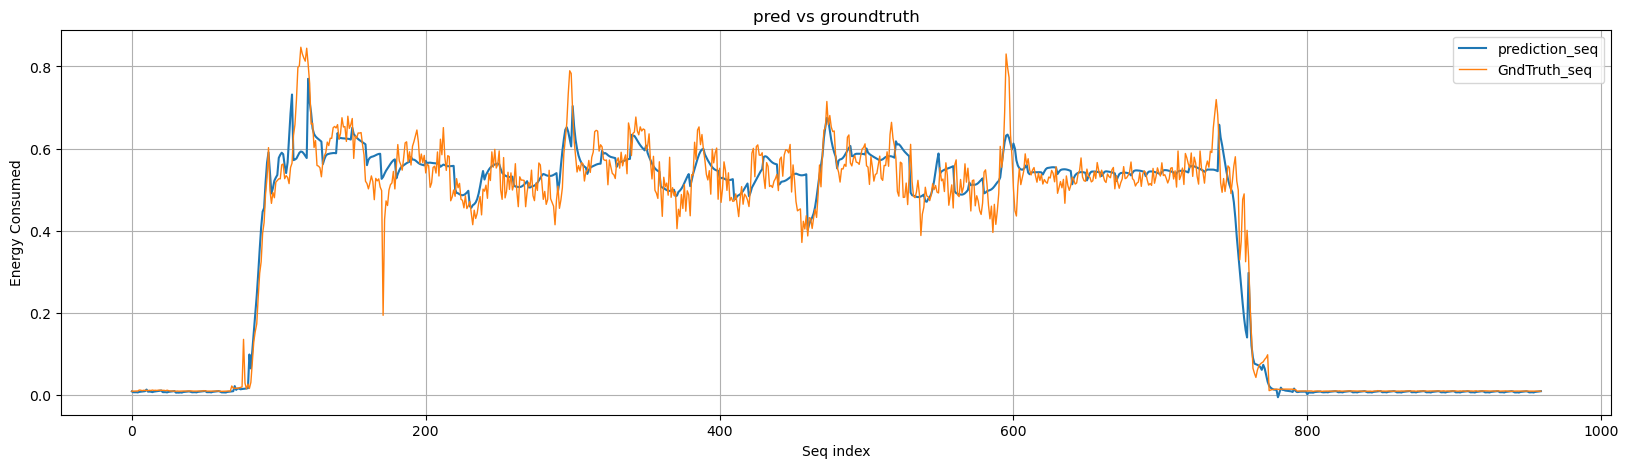

In [7]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'LSTM_LSTM_select_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
flight_num = 276 #random.randint(0, 100)
test_data = data[data['flight'] == flight_num]
input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                         test_data['power'].values, input_len, output_len)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

with torch.no_grad():
    
    outputs = seq2seq(input_seq)  # No need for target length
    # Adjust the dimensions if necessary, based on your loss function requirements
    # Example: If your outputs and targets are both [batch_size, 2, 1]
    outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
    targets = output_seq

    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    print(f"MAPE: {mape}")
    
    plot_output(outputs.cpu(), targets.cpu(), output_len)


In [8]:
# test the model
seq2seq.eval()
mape_list = []

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.no_grad():
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1)
        
    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    mape_list.append(mape.item())

print(f"Test MAPE: {sum(mape_list)/len(mape_list)}")


Test MAPE: 16.72175439978784


Dataloader

In [ ]:
"""
TODO:

1. Get rid of the head and tail of the data

2. Debug invalid data when specifying the flight number

3. By paper: 'We used a total of 114 training flights (4 hours and 4 minutes flight time), 38 validation flights 
(1 hour and 24 minutes flight time) and 37 test flights (1 hour and 23 minutes flight time).' Should we do the same?

4. Decoder input (i.e., future trajectory as inputs)

"""